Essential libraries imported

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,  precision_score, recall_score, f1_score, roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import time

Suppress warnings

In [8]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


Load dataset

In [9]:
df=pd.read_csv("AIML Dataset.csv")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [12]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

Analyze transaction types and fraud rates, visualize distributions

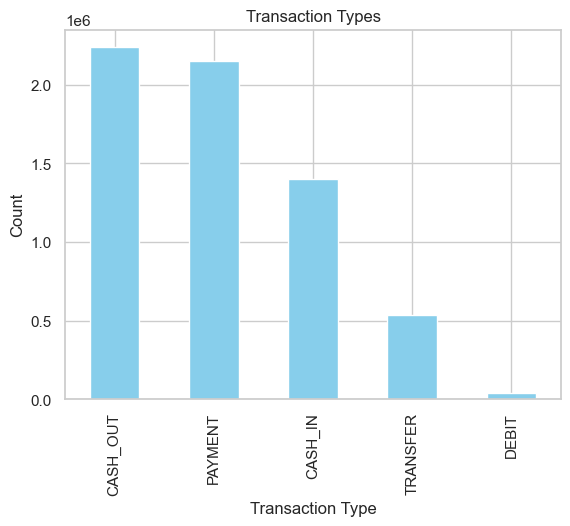

In [13]:


df["type"].value_counts().plot(kind="bar", title="Transaction Types", color="skyblue" )
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


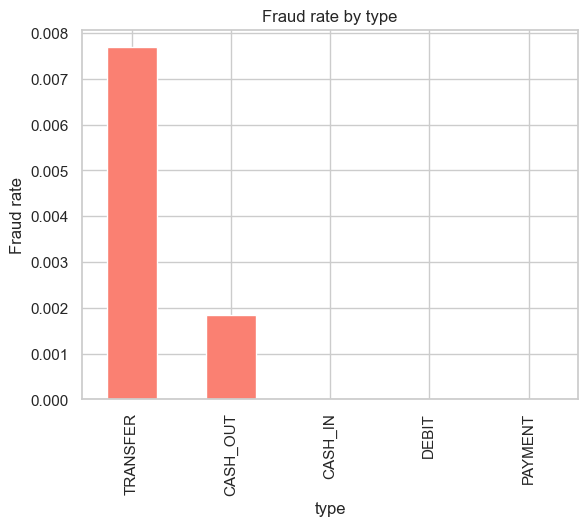

In [14]:
# Fraud rate by type
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar",title="Fraud rate by type", color="salmon")
plt.ylabel("Fraud rate")
plt.show()

In [15]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

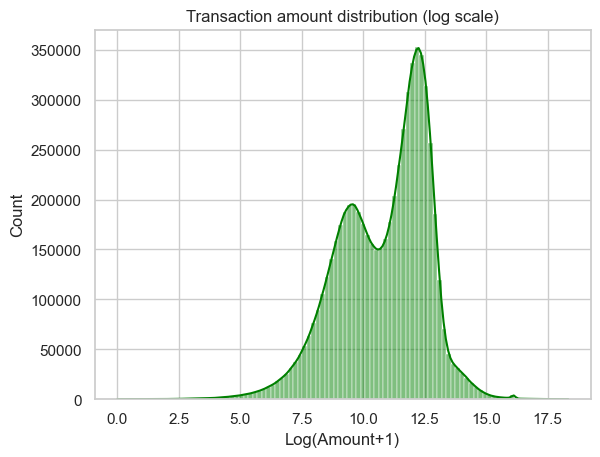

In [16]:
# Transaction amount distribution (log scale)
sns.histplot(np.log1p(df["amount"]),bins=100,kde=True,color="green")
plt.title("Transaction amount distribution (log scale)")
plt.xlabel("Log(Amount+1)")
plt.show()

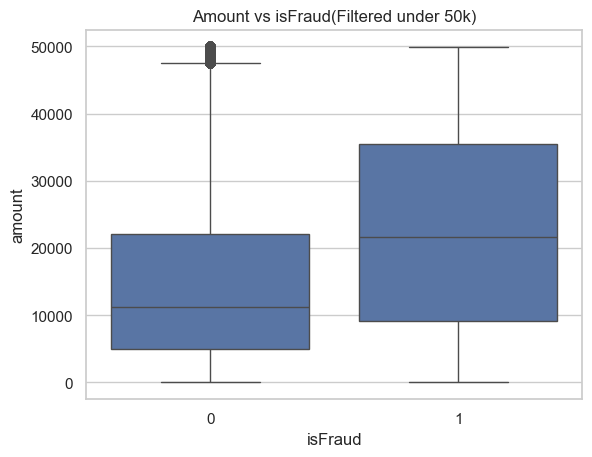

In [17]:
# Boxplot of amount vs fraud (filtered to amounts < 50k)
sns.boxplot(data=df[df["amount"]<50000],x="isFraud",y="amount")
plt.title("Amount vs isFraud(Filtered under 50k)")
plt.show()

In [18]:
df["balanceDiffOrig"]=df["oldbalanceOrg"]-df["newbalanceOrig"]
df["balanceDiffDest"]=df["newbalanceDest"]-df["oldbalanceDest"]

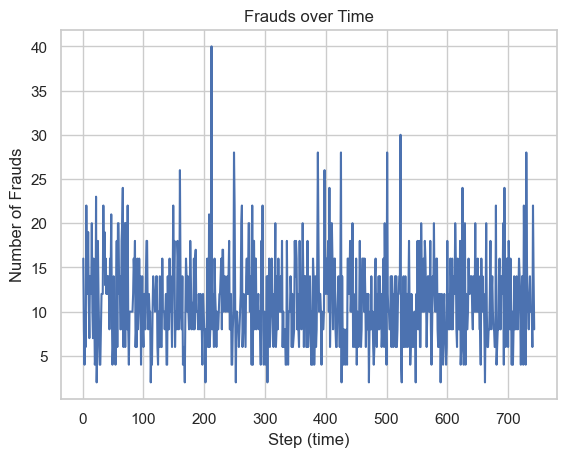

In [19]:
# Time-based fraud analysis
frauds_per_set=df[df["isFraud"]==1]["step"].value_counts().sort_index()
plt.plot(frauds_per_set.index,frauds_per_set.values,label="Frauds per set")
plt.xlabel("Step (time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds over Time")
plt.grid(True)
plt.show()


In [20]:
df.drop(columns="step",inplace=True)

In [21]:
top_senders=df["nameOrig"].value_counts().head(10)

In [22]:
top_receivers=df["nameDest"].value_counts().head(10)

In [23]:
fraud_users=df[df["isFraud"]==1]["nameOrig"].value_counts().head(10)

In [24]:
# Fraud distribution for specific types
fraud_types=df[df["type"].isin(["TRANSFER","CASH_OUT"])]

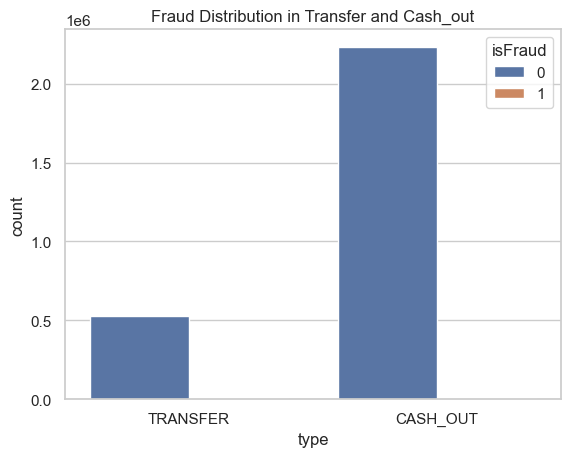

In [25]:
sns.countplot(data=fraud_types,x="type",hue="isFraud")
plt.title("Fraud Distribution in Transfer and Cash_out")
plt.show()

In [26]:

# Correlation heatmap
corr=df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]].corr()

In [27]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000


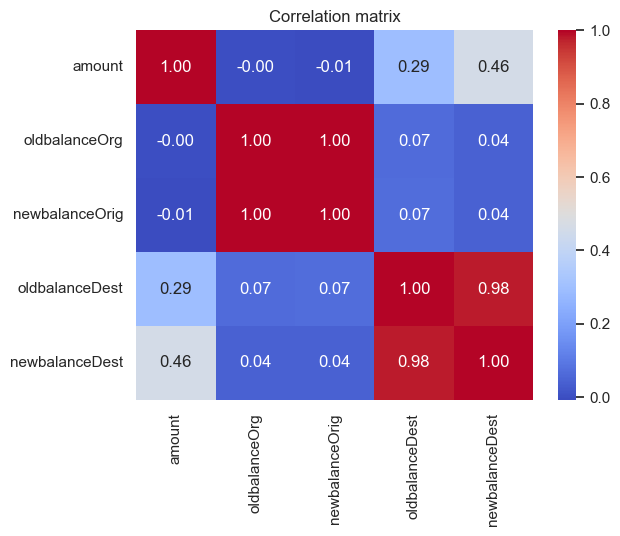

In [28]:
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [29]:
zero_after_transfer=df[(df["oldbalanceOrg"]>0)&
                       (df["newbalanceOrig"]==0)&
                       (df["type"].isin(["TRANSFER","CASH_OUT"]))]

In [30]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

 Prepare Data for Modeling

In [31]:
df_model=df.drop(["nameOrig","nameDest","isFlaggedFraud"],axis=1)

In [4]:
categorical=["type"]
numeric=["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

In [32]:
y=df_model["isFraud"]
X=df_model.drop("isFraud",axis=1)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [34]:
# Preprocessing pipeline: scale numeric and one-hot encode categorical
preprocessor=ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),numeric),
        ("cat",OneHotEncoder(drop="first"),categorical)
    ],
    remainder="drop"
)

In [84]:
smote = SMOTE(sampling_strategy=0.3, random_state=42)

In [71]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)


Model Training and Evaluation

In [85]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("classifier", rf_model)
])

In [86]:
start = time.time()
pipeline.fit(X_train, y_train)
end = time.time()

print(f"⏱️ Training time: {(end - start):.2f} seconds")

⏱️ Training time: 66.41 seconds


In [94]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Threshold tuning loop
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    score = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} => F1 Score: {score:.4f}")
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1 Score: {best_f1:.4f}")

# Final prediction using best threshold
y_pred_final = (y_proba >= best_thresh).astype(int)

Threshold: 0.10 => F1 Score: 0.0459
Threshold: 0.15 => F1 Score: 0.0564
Threshold: 0.20 => F1 Score: 0.0650
Threshold: 0.25 => F1 Score: 0.0839
Threshold: 0.30 => F1 Score: 0.1050
Threshold: 0.35 => F1 Score: 0.1126
Threshold: 0.40 => F1 Score: 0.1207
Threshold: 0.45 => F1 Score: 0.1317
Threshold: 0.50 => F1 Score: 0.1473
Threshold: 0.55 => F1 Score: 0.1664
Threshold: 0.60 => F1 Score: 0.1870
Threshold: 0.65 => F1 Score: 0.2138
Threshold: 0.70 => F1 Score: 0.2503
Threshold: 0.75 => F1 Score: 0.3096
Threshold: 0.80 => F1 Score: 0.3955
Threshold: 0.85 => F1 Score: 0.5311

Best threshold: 0.85 with F1 Score: 0.5311


In [95]:
print(classification_report(y_test,y_pred_final))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.37      0.94      0.53      2464

    accuracy                           1.00   1908786
   macro avg       0.68      0.97      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786



In [96]:
confusion_matrix(y_test,y_pred_final)

array([[1902353,    3969],
       [    138,    2326]])

In [97]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_final)
print("F1 Score:", round(f1, 4))

F1 Score: 0.5311


In [98]:
accuracy = pipeline.score(X_test, y_test) * 100
print("Accuracy:", round(accuracy, 2), "%")

Accuracy: 98.52 %


In [99]:
pipeline.score(X_test,y_test)*100

98.51822048149977